In [1]:
import pickle
import sys
import inspect
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from rdkit import Chem, DataStructs, RDLogger
from rdkit.Chem import AllChem

from rad.construction import getGraphs
from rad.traversal import traverseHNSW
from utils.paths import radsmina_path, data_path

# Disable rdkit error logging to keep output clean
RDLogger.DisableLog('rdApp.*')  

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for std::vector<int, std::allocator<int> > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for std::vector<double, std::allocator<double> > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for std::vector<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, std::allocator<std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> > > > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for std::vector<unsigned long, std::allocator<unsigned long> > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for std::vector<std::vector<double, std::allocator<double> >, std::allocator<s

### Load the SMILES dataset

In [2]:
input_pickle = "goldilocks_smiles.pkl"
with open(input_pickle, 'rb') as f:
    dudez_data = pickle.load(f)

In [3]:
print(f"Loaded {len(dudez_data)} molecules from {input_pickle}.")

Loaded 132884 molecules from goldilocks_smiles.pkl.


### Set parameters for fingerprints and generate them

In [4]:
FP_LENGTH = 1024
FP_RADIUS = 2

In [5]:
failed_smiles = []  # List to store failed SMILES
successful_count = 0  # Counter for successful molecules

In [6]:
dudez_fps = [] ## To store molecular fingerprints in a compact binary form (packed bits).
node_id = 0 ## A unique identifier for each molecule (node).

# Store a mapping from node_id -> zID
id_to_zid = []

for zid in tqdm(dudez_data, total=len(dudez_data), desc="Generating Fingeprints"):
    smi = dudez_data[zid] ## SMILES string for the molecule.

    # Some smiles will fail molecule generation. We just skip them
    mol = Chem.MolFromSmiles(smi) ## The RDKit library converts the SMILES string into a molecular object
    if mol is None:
        ## Log failed SMILES
        failed_smiles.append(smi)
        continue
    
    # If successful, process as usual
    successful_count += 1
    # Convert rdkit bit vect fingerprint to numpy array
    arr = np.zeros((1,), dtype=np.uint8)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=FP_RADIUS, nBits=FP_LENGTH) ## Generate Molecular Fingerprints
    DataStructs.ConvertToNumpyArray(fp, arr) ## Convert Morgan Fingerprints to NumPy Array

    # IMPORTANT: Make sure to pack bit fingerprints - it vastly speeds up HNSW construction
    dudez_fps.append(np.packbits(arr)) 
    ## Groups every 8 bits into a single byte.
    ## Reduces the length of the array by a factor of 8 (e.g., from 1024 bits to 128 bytes).
    
    id_to_zid.append(zid) # Record that node_id corresponds to this zID
    
    node_id += 1 ## Every molecule gets a unique identifier

dudez_fps = np.array(dudez_fps) ## Convert Fingerprints List to NumPy Array
# Output results
print(f"Total SMILES processed: {len(dudez_data)}")
print(f"Successful molecule generation: {successful_count}")
print(f"Failed SMILES count: {len(failed_smiles)}")
print("Failed SMILES examples:", failed_smiles[:10])  # Print a few failed SMILES

Generating Fingeprints: 100%|██████████| 132884/132884 [00:27<00:00, 4835.07it/s]


Total SMILES processed: 132884
Successful molecule generation: 132881
Failed SMILES count: 3
Failed SMILES examples: ['1=CC=C(CCC[N@@H+]2C[C@@H]3CC[C@H](C2)N(C[C@H]2[C@@H]4C[NH2+]C[C@H]24)C3)C=C1', '=C(NCC1=CC=CN=C1)[C@H]1[C@@H]2C[N@@H+](C[C@@H]3C[C@H]4C=C[C@@H]3C4)C[C@@H]21', '[C@H]2[C@H]3C=C[C@H](C3)[C@@H]2C(=O)N1NC1=CC=C([N+](=O)[O-])C=C1[N+](=O)[O-]']


### Set parameters for HNSW and construct it

In [7]:
EF_CONSTRUCTION = 400 ## graph_quality
M = 16 ## max_neighbours_node

In [8]:
hnsw_layer_graphs, hnsw_index = getGraphs(dudez_fps, ef_construction=EF_CONSTRUCTION, M=M)
element_levels = hnsw_index["element_levels"]
max_level = hnsw_index["max_level"]

for lvl in range(max_level + 1):
    num_nodes_in_layer = np.sum(element_levels >= lvl)
    print(f"Number of nodes in layer {lvl}: {num_nodes_in_layer}")

HNSW Construction time: 44.40401077270508 seconds


Formatting hnswlib Neighbor Data: 132881it [00:00, 452765.74it/s]
Constructing graph_tool graphs:  97%|█████████▋| 129317/132881 [00:02<00:00, 52344.00it/s]

Adding batch 0/0 to graphs


Constructing graph_tool graphs: 100%|██████████| 132881/132881 [00:05<00:00, 23232.93it/s]

Number of nodes in layer 0: 132881
Number of nodes in layer 1: 8231
Number of nodes in layer 2: 494
Number of nodes in layer 3: 30
Number of nodes in layer 4: 1


### Build file index for quicker traversal

In [9]:
import os
import json
import time
from smina.dock import dock_with_smina
from smina.utils import build_library_index, retrieve_mol2_file, get_ligand_block

In [10]:
folder_dir = data_path("super_goldilocks")
big_index = build_library_index(folder_dir)
print(len(big_index))

132884


### Measure Retirval Time vs. Offset

In [11]:
import random
def measure_retrieval_times(big_index, sample_size=2000):
    """
    1) Randomly pick 'sample_size' ligands from big_index keys.
    2) For each, measure time to call get_ligand_block(mol2_path, offset).
    3) Return two lists: offsets, times.
    """
    all_ligands = list(big_index.keys())
    
    # randomly pick a subset as the big_index is huge,
    sample_ligands = random.sample(all_ligands, min(sample_size, len(all_ligands)))

    offsets = []
    times = []

    for ligand_id in sample_ligands:
        mol2_path, offset = big_index[ligand_id]
        
        start_t = time.perf_counter()
        block = get_ligand_block(mol2_path, offset)  # offset-based retrieval
        end_t = time.perf_counter()
        
        retrieval_time = end_t - start_t
        
        offsets.append(offset)
        times.append(retrieval_time)

    return offsets, times

In [12]:
import matplotlib.pyplot as plt

def plot_offset_vs_time(offsets, times):
    """
    Plots a scatter of offset (x-axis) vs retrieval time (y-axis).
    """
    plt.figure(figsize=(8,6))
    plt.scatter(offsets, times, alpha=0.6)
    plt.title("Retrieval Time vs. Offset")
    plt.xlabel("Byte Offset in .mol2 file")
    plt.ylabel("Retrieval Time (seconds)")
    plt.show()

Average retrieval time (seconds): 0.0008192244946141626


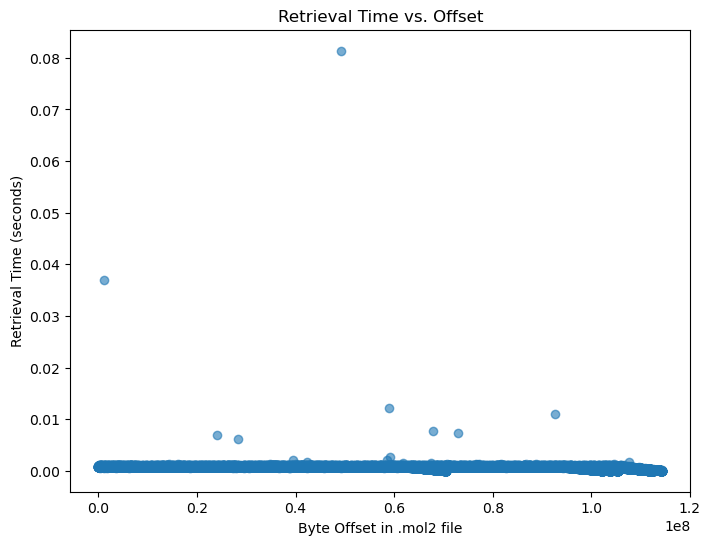

In [20]:
offsets, times = measure_retrieval_times(big_index, sample_size=132884)
average_time = sum(times) / len(times)
print(f"Average retrieval time (seconds): {average_time}")
plot_offset_vs_time(offsets, times)

### Define the receptor and receptor ligand

In [21]:
RECEPTOR = "ROCK1"
NUM_TO_TRAVERSE = 10000 # Maximum number of molecules to score

In [33]:
receptor_pdb = os.path.join(data_path("receptor_files"),f"{RECEPTOR}.pdb")
reclig_pdb = os.path.join(data_path("reclig_files"),f"{RECEPTOR}-lig.pdb")

### Debug function

In [14]:
def write_block_to_temp_mol2(block, ligand_id):
    import tempfile, os

    # Create a unique temp .mol2 file name
    tmp = tempfile.NamedTemporaryFile(suffix=".mol2", delete=False)
    tmp_mol2_path = tmp.name
    tmp.close()  # We only needed the name

    # Write the block lines
    with open(tmp_mol2_path, "w") as f:
        f.writelines(block)

    # [DEBUG] Now read back the file contents so you can print them
    with open(tmp_mol2_path, "r") as dbg:
        debug_text = dbg.read()
    print(f"[DEBUG] The block for {ligand_id} was written to {tmp_mol2_path}. Here are its contents:\n{debug_text}")

    return tmp_mol2_path

### Traverse HNSW with Smina using 1 receptor

In [34]:
scores_by_node = {}  # node_id -> docking score
def score_fn(node_id):
    start_all = time.perf_counter()

    # 1) bounds check + get ligand ID
    stage1_start = time.perf_counter()
    if node_id < 0 or node_id >= len(id_to_zid):
        return np.inf
    ligand_id = id_to_zid[node_id]
#     print(f"[DEBUG] node_id={node_id} => ligand_id={ligand_id}")
    
#     # Check if in big_index
    if ligand_id not in big_index:
#         print(f"[DEBUG] {ligand_id} not in big_index.")
        return np.inf
    smi = dudez_data[ligand_id]
    mol2_path, offset = big_index[ligand_id]
    stage1_end = time.perf_counter()
#     print(f"[DEBUG] Found offset={offset} in {mol2_path} for {ligand_id}")

    # 2) retrieve temp .mol2
    stage2_start = time.perf_counter()
    mol2_temp = retrieve_mol2_file(ligand_id, big_index)
    stage2_end = time.perf_counter()
    
#     block = get_ligand_block(mol2_path, offset)
    # Write and debug-print the block
#     mol2_temp1 = write_block_to_temp_mol2(block, ligand_id)
    if not mol2_temp:
        # either not found or offset read failed
        return np.inf

    # 3) dock
    stage3_start = time.perf_counter()
    best_score,mol2_text = dock_with_smina(mol2_temp, receptor_pdb, reclig_pdb)
    best_pose_output = os.path.join(radsmina_path("best_pose_output"), f"{ligand_id}_bestpose.mol2")
    with open(best_pose_output, "w") as f:
        f.write(mol2_text)
    stage3_end = time.perf_counter()
    # remove the temp file
    stage4_start = time.perf_counter()
    os.remove(mol2_temp)
    stage4_end = time.perf_counter()

    if best_score is None:
        print(f"[DEBUG] dock_with_smina_mol2 returned None for {ligand_id}")
        return np.inf
    
    scores_by_node[ligand_id] = [node_id, smi, best_score]
    end_all = time.perf_counter()
    # Print or log times for debugging
    stage1_time = stage1_end - stage1_start
    stage2_time = stage2_end - stage2_start
    stage3_time = stage3_end - stage3_start
    stage4_time = stage4_end - stage4_start
    total_time = end_all - start_all
    
    print(f"[DEBUG] score_fn times for node {node_id}:")
    print(f"  Stage 1 (big_index lookup): {stage1_time:.4f}s")
    print(f"  Stage 2 (retrieve mol2): {stage2_time:.4f}s")
    print(f"  Stage 3 (docking): {stage3_time:.4f}s")
    print(f"  Stage 4 (cleanup): {stage4_time:.4f}s")
    print(f"  TOTAL: {total_time:.4f}s")
    
    return best_score

In [ ]:
traversed_nodes = traverseHNSW(hnsw_layer_graphs, score_fn, NUM_TO_TRAVERSE)

### Store the Smina docking socres

In [ ]:
with open("zid_scores_rock1.json", "w") as f:
    json.dump(scores_by_node, f, indent=2)